In [20]:
# [1] 패키지 참조
from hossam import load_data, my_dpi
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [21]:
# [2] 데이터 가져오기
origin = load_data("cars")
origin.head()

자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리



,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [22]:
# 기본 통계량
desc = origin.describe().T
desc

,count,mean,std,min,25%,50%,75%,max
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0


In [23]:
# 결측치 확인
desc["missing"] = origin.isnull().sum()
desc

,count,mean,std,min,25%,50%,75%,max,missing
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0,0
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0,0


In [24]:
# IQR, 이상치 확인
Q1 = origin.quantile(0.25)
Q3 = origin.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_count = ((origin < lower_bound) | (origin > upper_bound)).sum()
outlier_ratio = outlier_count / len(origin) * 100
desc["outlier_count"] = outlier_count
desc["outlier_ratio(%)"] = outlier_ratio
desc

,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%)
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0,0,0,0.0
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0,0,1,2.0


In [25]:
# 왜도 및 로그 변환 필요성 확인
skewness_results = []
for column in origin.columns:
    skewness = origin[column].skew()
    if abs(skewness) < 0.5:
        strength = "week"
        log_transform = "not needed"
    elif abs(skewness) < 1:
        strength = "normal"
        log_transform = "recommended"
    else:
        strength = "strong"
        log_transform = "needed"
    desc.loc[column, "skewness"] = skewness
    desc.loc[column, "skewness_strength"] = strength
    desc.loc[column, "log_transform"] = log_transform
desc

,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%),skewness,skewness_strength,log_transform
speed,50.0,15.40,5.287644,4.0,12.0,15.0,19.0,25.0,0,0,0.0,-0.117510,week,not needed
dist,50.0,42.98,25.769377,2.0,26.0,36.0,56.0,120.0,0,1,2.0,0.806895,normal,recommended


In [26]:
# 로그 변환
df = origin.copy()
df["dist"] = np.log1p(df["dist"])
df.head()

,speed,dist
0,4,1.098612
1,4,2.397895
2,7,1.609438
3,7,3.135494
4,8,2.833213


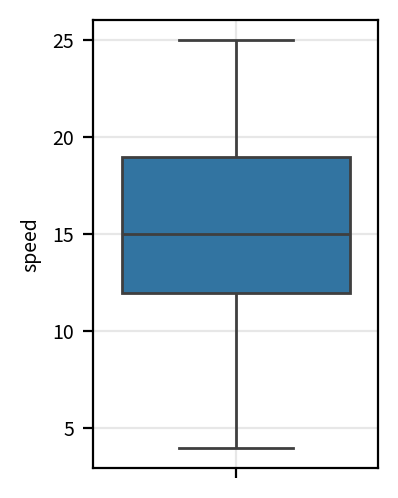

In [27]:
# 상자그림 확인
figsize = (400 / my_dpi, 500 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)
sb.boxplot(data=df, y="speed")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [28]:
# 독립변수 분리
x = df[["speed"]]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


In [29]:
# 종속변수 분리
y = df["dist"]
y.head()

0    1.098612
1    2.397895
2    1.609438
3    3.135494
4    2.833213
Name: dist, dtype: float64

In [30]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
display(x_train.head())
display(y_train.head())
display(x_test.head())
display(y_test.head())

(37, 1) (13, 1) (37,) (13,)


,speed
0,4
44,23
25,15
29,17
43,22


0     1.098612
44    4.007333
25    4.007333
29    3.713572
43    4.204693
Name: dist, dtype: float64

,speed
19,14
3,7
26,16
40,20
8,10


19    3.295837
3     3.135494
26    3.496508
40    3.970292
8     3.555348
Name: dist, dtype: float64

In [31]:
# 선형회귀 모델 구축
estimator = LinearRegression(n_jobs=-1)
estimator.fit(x_train, y_train)
print("계수(기울기): ", estimator.coef_)
print("절편: ", estimator.intercept_)
print("훈련 데이터 설명력: ", estimator.score(x_train, y_train))
print("검증 데이터 설명력: ", estimator.score(x_test, y_test))

계수(기울기):  [0.12418778]
절편:  1.612634340409837
훈련 데이터 설명력:  0.7126860464637156
검증 데이터 설명력:  0.42272544385910227


In [32]:
# 회귀식 추정
print(f"log(dist) = {estimator.coef_[0]:.4f} * speed + {estimator.intercept_:.4f}")

log(dist) = 0.1242 * speed + 1.6126


In [33]:
# 훈련 데이터에 대한 예측값
y1 = estimator.predict(x_train)
y1

array([2.10938547, 4.46895332, 3.47545107, 3.72382663, 4.34476554,
       2.48194881, 3.35126329, 3.35126329, 4.59314111, 2.6061366 ,
       2.85451216, 3.10288772, 3.72382663, 3.22707551, 4.59314111,
       2.97869994, 3.10288772, 4.59314111, 3.9722022 , 4.09638998,
       3.22707551, 4.09638998, 3.9722022 , 4.09638998, 3.84801441,
       4.09638998, 3.9722022 , 3.59963885, 4.59314111, 2.73032438,
       3.84801441, 4.71732889, 3.35126329, 3.47545107, 3.10288772,
       3.10288772, 3.72382663])

In [34]:
# 검증 데이터에 대한 예측값
y2 = estimator.predict(x_test)
y2

array([3.35126329, 2.48194881, 3.59963885, 4.09638998, 2.85451216,
       2.97869994, 3.47545107, 2.85451216, 3.84801441, 3.84801441,
       3.22707551, 2.10938547, 3.22707551])

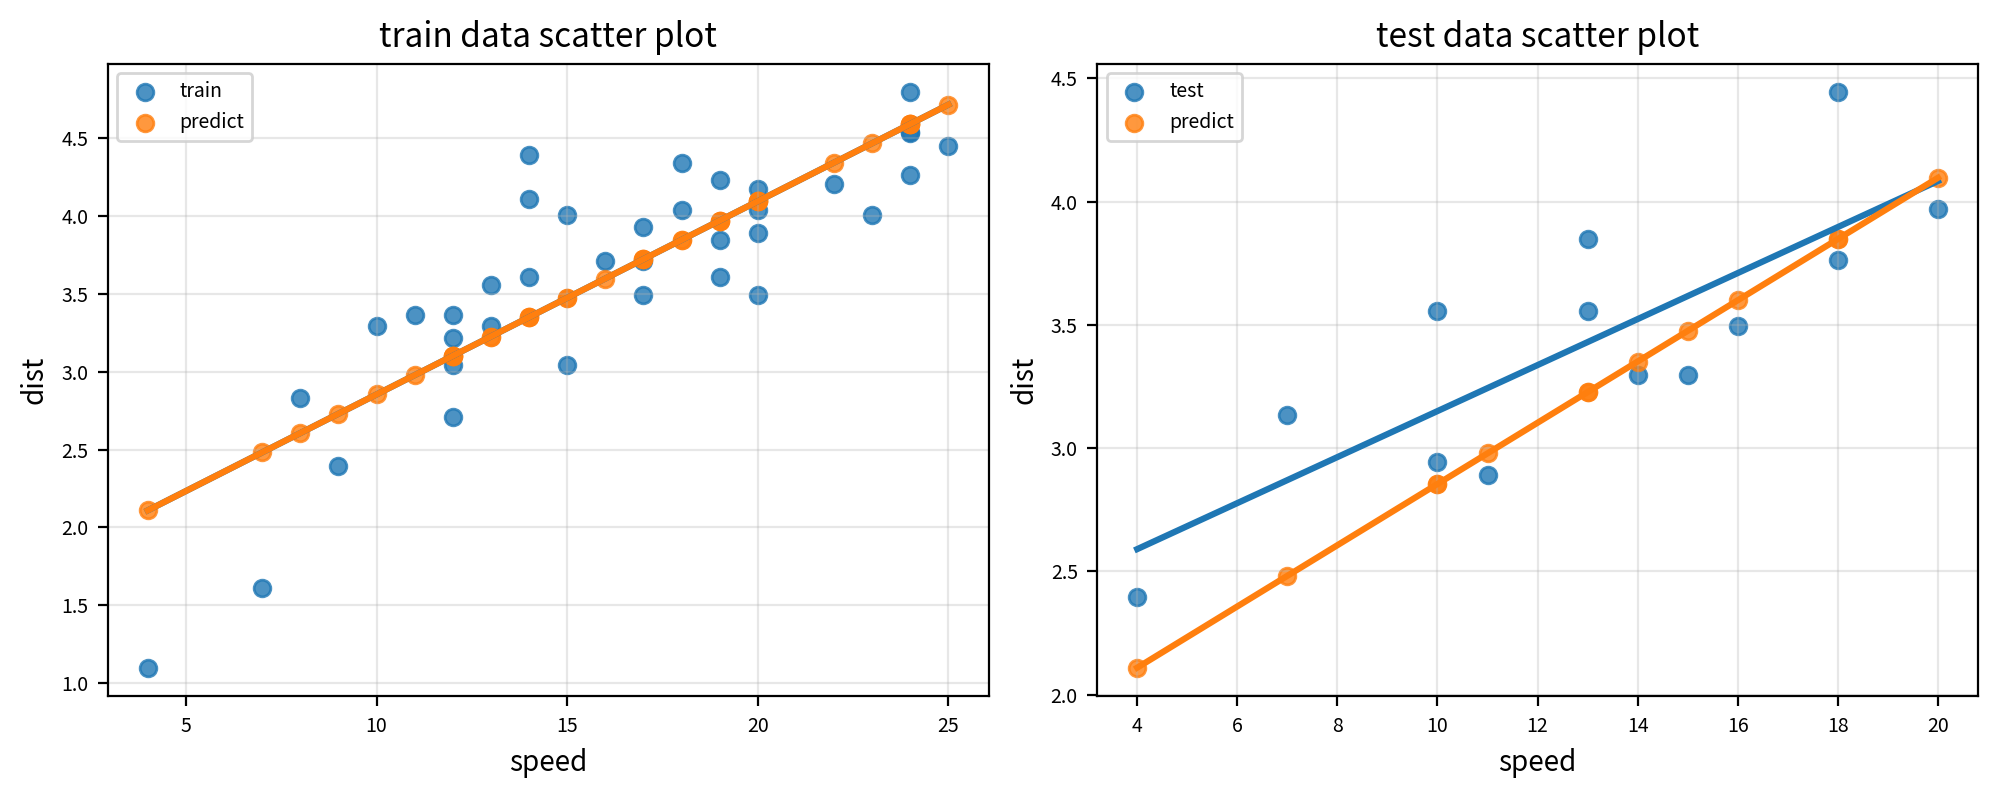

In [35]:
# 분석 결과 시각화
figsize = (2000 / my_dpi, 800 / my_dpi)
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)
fig.subplots_adjust(wspace=0.2, hspace=0.2)

# 훈련 데이터 시각화
sb.regplot(data=x_train, x="speed", y=y_train, ci=0, label="train", ax=ax[0])
sb.regplot(data=x_train, x="speed", y=y1, ci=0, label="predict", ax=ax[0])
ax[0].set_title("train data scatter plot", fontsize=12)
ax[0].set_xlabel("speed", fontsize=10)
ax[0].set_ylabel("dist", fontsize=10)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 검증 데이터 시각화
sb.regplot(data=x_test, x="speed", y=y_test, ci=0, label="test", ax=ax[1])
sb.regplot(data=x_test, x="speed", y=y2, ci=0, label="predict", ax=ax[1])
ax[1].set_title("test data scatter plot", fontsize=12)
ax[1].set_xlabel("speed", fontsize=10)
ax[1].set_ylabel("dist", fontsize=10)
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [36]:
# 새로운 관측값
new_X = DataFrame({"speed": [40], "dist": [100]})
new_X["dist"] = np.log(new_X["dist"])
new_X = new_X[["speed", "dist"]]
new_X.head()

,speed,dist
0,40,4.60517


In [38]:
# 예측
y_pred = estimator.predict(new_X[["speed"]])
new_X["dist_pred"] = np.expm1(y_pred)
new_X

,speed,dist,dist_pred
0,40,4.60517,719.644259
